# Requirements

In [ ]:
!pip install transformers torch numpy pandas scikit-learn seaborn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

# Libraries

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Paths and Config

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
EPOCHS = 5
LR = 2e-5

# Paths
X_PATH = "/content/drive/MyDrive/sentiment4/features_vault/merged/X_features_vault.npy"
Y_PATH = "/content/drive/MyDrive/sentiment4/features_vault/merged/y_labels_vault.npy"
VIDEO_NAMES_PATH = "/content/drive/MyDrive/sentiment4/features_vault/merged/X_videonames_vault.npy"
CSV_PATH = "/content/drive/MyDrive/sentiment/df_expanded_latest.csv"

In [ ]:
# Load
X = np.load(X_PATH)
y = np.load(Y_PATH)
video_names = np.load(VIDEO_NAMES_PATH, allow_pickle=True)

# Dataframe

In [ ]:
df = pd.read_csv(CSV_PATH)
# Filter and format the DataFrame
df = df[df['label'].isin([0, 1])].copy()
df['input_text'] = df['input_text'].fillna("").astype(str)
df['label'] = df['label'].astype(int)

df = df[['input_text', 'label', 'subtitle_path', 'text']]
# display(df.head())

In [ ]:
# Fix index out-of-bound mismatch if any
video_names = video_names[:len(X)]

# Group frame features by video name
vision_dict = defaultdict(list)
for i, vname in enumerate(video_names):
    vision_dict[vname].append(X[i])

# Group subtitle entries by subtitle_path
subtitle_dict = defaultdict(list)
for i, row in df.iterrows():
    subtitle_dict[row['subtitle_path']].append((row['input_text'], row['label'], row['text']))  # 'text' is the word

matched_texts, matched_labels, matched_vision, matched_words, matched_subpaths = [], [], [], [], []

for vid in subtitle_dict:
    subs = subtitle_dict[vid]
    frames = vision_dict.get(vid, [])

    if not frames:
        continue  # skip if no vision

    if len(frames) >= len(subs):
        used_frames = frames[:len(subs)]
    else:
        used_frames = frames + [frames[-1]] * (len(subs) - len(frames))  # pad

    for i in range(len(subs)):
        matched_texts.append(subs[i][0])       # input_text
        matched_labels.append(subs[i][1])      # label
        matched_words.append(subs[i][0])       # word (same as input_text for now)
        matched_vision.append(used_frames[i])  # vision embedding
        matched_subpaths.append(vid)           # subtitle_path

min_len = min(len(matched_texts), len(matched_labels), len(matched_words), len(matched_vision), len(matched_subpaths))

matched_texts = matched_texts[:min_len]
matched_labels = matched_labels[:min_len]
matched_words = matched_words[:min_len]
matched_vision = matched_vision[:min_len]
matched_subpaths = matched_subpaths[:min_len]

# Final dataset
print(f"✅ Aligned {len(matched_texts)} samples")
X = np.stack(matched_vision)
y = np.array(matched_labels)

# Final dataset
df = pd.DataFrame({
    "input_text": matched_texts,
    "label": matched_labels,
    "word": matched_words,
    "subtitle_path": matched_subpaths
})

✅ Aligned 219281 samples


# Data Split

In [ ]:
# Splits
train_df, temp_df, train_idx, temp_idx = train_test_split(df, np.arange(len(df)), test_size=0.4, stratify=df['label'], random_state=42)
val_df, test_df, val_idx, test_idx = train_test_split(temp_df, temp_idx, test_size=0.5, stratify=temp_df['label'], random_state=42)

In [ ]:
# Align video names
video_names = np.array(video_names)
train_vnames = video_names[train_idx]
val_vnames = video_names[val_idx]
test_vnames = video_names[test_idx]

# Dataset Preparation

In [ ]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Dataset class
class VaultPrecomputedDataset(Dataset):
    def __init__(self, dataframe, vision_features, video_names, tokenizer):
        self.df = dataframe.reset_index(drop=True)
        self.vision = vision_features
        self.video_names = video_names
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # ✅ Load full subtitle from file
        subtitle_text = ""
        try:
            with open(row["subtitle_path"], "r") as f:
                subtitle_text = f.read().strip()
        except:
            subtitle_text = row["input_text"]  # fallback to short text

        encoded = self.tokenizer(
            subtitle_text,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "vision_features": torch.tensor(self.vision[idx], dtype=torch.float),
            "label": torch.tensor(int(row["label"]), dtype=torch.long),
            "video_name": self.video_names[idx],
            "word": row["word"],
            "subtitle": subtitle_text   # added so you can print it during debug
        }

In [ ]:
# Dataloaders
train_set = VaultPrecomputedDataset(train_df, X[train_idx], train_vnames, tokenizer)
val_set = VaultPrecomputedDataset(val_df, X[val_idx], val_vnames, tokenizer)
test_set = VaultPrecomputedDataset(test_df, X[test_idx], test_vnames, tokenizer)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [ ]:
print(len(train_set), len(val_set), len(test_set))
print(len(train_loader), len(val_loader), len(test_loader))

131568 43856 43857
4112 1371 1371


# Model

In [ ]:
class VaultWithPrecomputedVision(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased", vision_feature_dim=256, fused_dim=512):
        super().__init__()
        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_proj = nn.Linear(self.text_encoder.config.hidden_size, fused_dim)
        self.vision_proj = nn.Linear(vision_feature_dim, fused_dim)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(fused_dim * 2, 2)

    def forward(self, input_ids, attention_mask, vision_features):
        text_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        proj_text = self.text_proj(text_out)
        proj_vision = self.vision_proj(vision_features)
        fused = self.dropout(torch.cat([proj_text, proj_vision], dim=1))
        return self.classifier(fused)

# Training

In [ ]:
def evaluate(model, loader, return_preds=False):
    model.eval()
    preds, probs, targets, names = [], [], [], []
    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            vision = batch["vision_features"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            logits = model(ids, mask, vision)
            prob = torch.softmax(logits, dim=1)
            pred = torch.argmax(prob, dim=1)

            preds.extend(pred.cpu().numpy())
            probs.extend(prob[:, 1].cpu().numpy())
            targets.extend(labels.cpu().numpy())
            names.extend(batch["video_name"])

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds)
    auc = roc_auc_score(targets, probs)
    return (acc, f1, auc, preds, targets, names) if return_preds else (acc, f1, auc)

# Train
def train(model, train_loader, val_loader, epochs):
    model.to(DEVICE)
    optim = torch.optim.AdamW(model.parameters(), lr=LR)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch_idx, batch in enumerate(train_loader, 1):
            ids = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            vision = batch["vision_features"].to(DEVICE)
            labels = batch["label"].to(DEVICE)

            optim.zero_grad()
            logits = model(ids, mask, vision)
            loss = loss_fn(logits, labels)
            loss.backward()
            optim.step()
            total_loss += loss.item()

            print(f"Epoch {epoch+1}: Batch {batch_idx}/{len(train_loader)}")

        acc, f1, auc = evaluate(model, val_loader)
        print(f"✅ Epoch {epoch+1}: Loss={total_loss:.2f} | Val Acc={acc:.4f} | F1={f1:.4f} | AUC={auc:.4f}")

In [ ]:
model = VaultWithPrecomputedVision()
train(model, train_loader, val_loader, EPOCHS)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x768 and 256x512)

# Performance

In [ ]:
acc, f1, auc, preds, targets, video_names_test = evaluate(model, test_loader, return_preds=True)
print(f"\n📊 Final Test: Accuracy={acc:.4f}, F1={f1:.4f}, AUC={auc:.4f}")


📊 Final Test: Accuracy=0.8495, F1=0.8499, AUC=0.9462


# Confusion Matrix

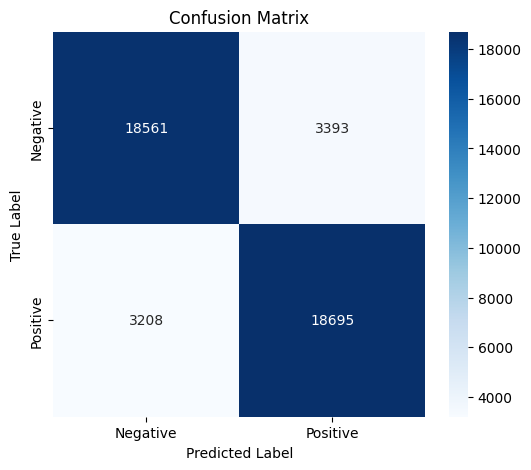

In [ ]:
conf_mat = confusion_matrix(targets, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Model Save

In [ ]:
SAVE_PATH = "/content/drive/MyDrive/final_models_saved/VAuLT-Baseline/vault_model_final.pt"
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
torch.save(model.state_dict(), SAVE_PATH)
print(f"✅ Model saved at: {SAVE_PATH}")

✅ Model saved at: /content/drive/MyDrive/final_models_saved/VAuLT-Baseline/vault_model_final.pt
